In [41]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import sys
from collections import defaultdict
sys.path.append("../4ncnn")
from data_utils import preprocess_sample
from pathlib import Path
from tifffile import imread

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
BASE_DIR = "/mnt/home/dchhantyal/3d-cnn-classification/data/nuclei_state_dataset/david4epi_extracted"
LABELS = ["mitotic", "new_daughter", "stable", "death"]
NUM_SAMPLES_PER_LABEL = 10

In [46]:
def plot_grid(images, ncols=4, label=None):
    nrows = (len(images) + ncols - 1) // ncols
    fig, axs = plt.subplots(nrows, ncols, figsize=(ncols * 2, nrows * 2))
    axs = axs.flatten()
    for i, img in enumerate(images):
        axs[i].imshow(np.mean(img, axis=0), cmap='gray')
        axs[i].axis('off')
        axs[i].set_title(f"shape: {img.shape}", fontsize=10)
    for i in range(len(images), len(axs)):
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


In [47]:
# Find random labels
datapoints = defaultdict(list)

for label in LABELS:
    label_dir = os.path.join(BASE_DIR, label)
    if not os.path.exists(label_dir):
        print(f"Directory {label_dir} does not exist.")
        continue
    
    files = [f for f in os.listdir(label_dir)]
    if not files:
        print(f"No files found in {label_dir}.")
        continue

    datapoints[label] = np.random.choice(files, NUM_SAMPLES_PER_LABEL, replace=False)


Directory /mnt/home/dchhantyal/3d-cnn-classification/data/nuclei_state_dataset/david4epi_extracted/death does not exist.


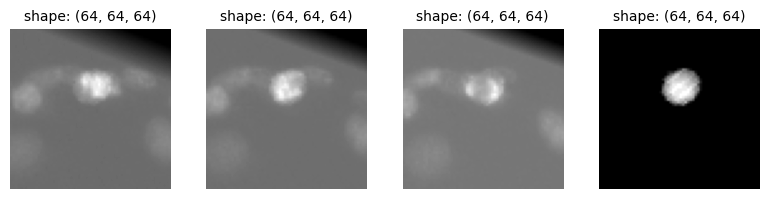

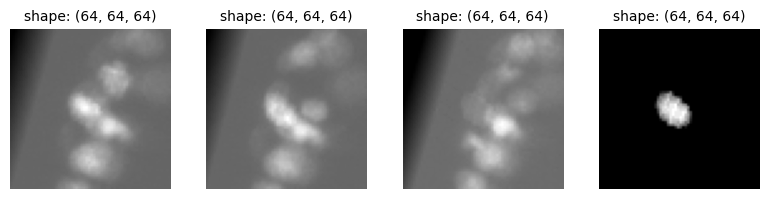

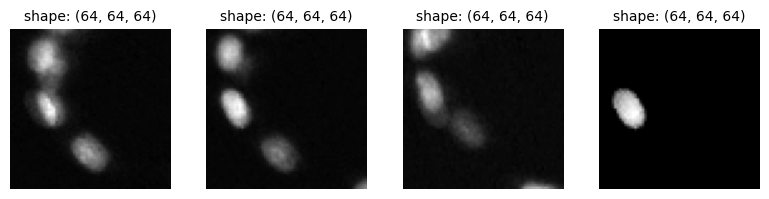

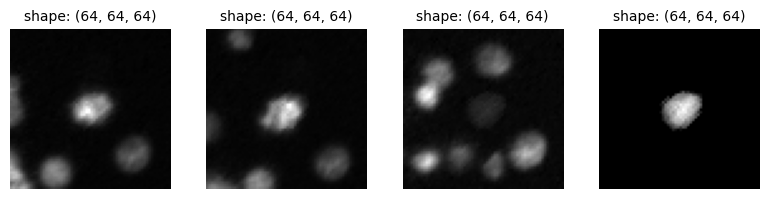

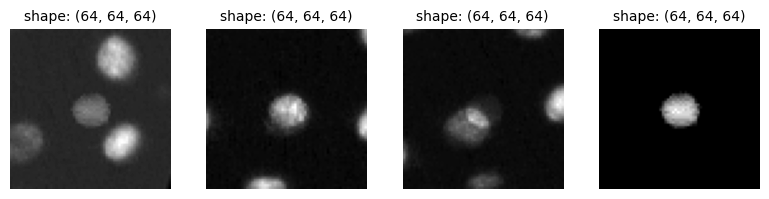

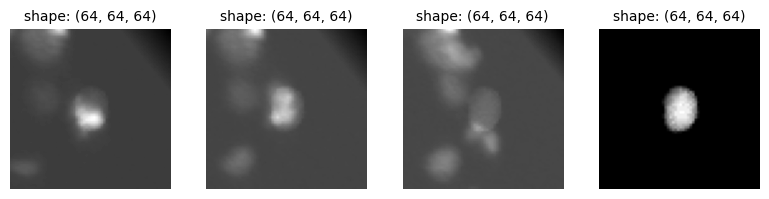

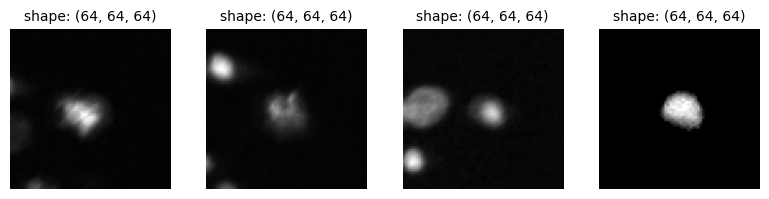

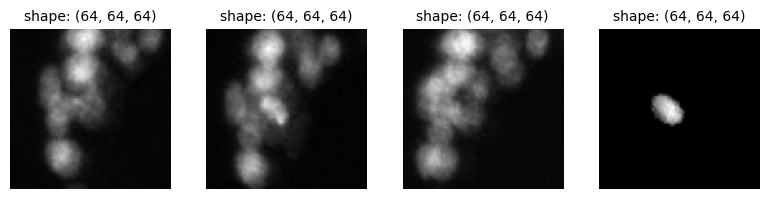

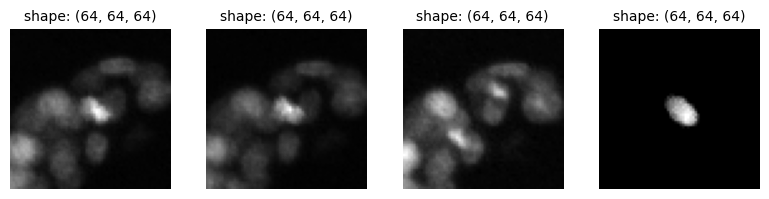

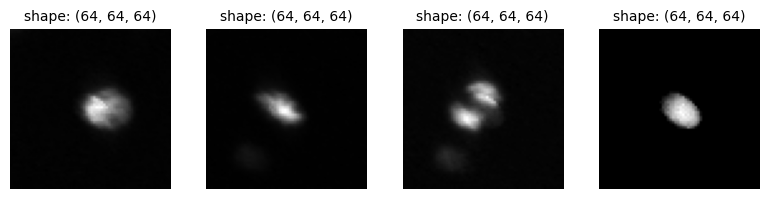

In [48]:
# MITOTIC
for file_path in datapoints["mitotic"]:
    folder_path = os.path.join(BASE_DIR, "mitotic", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path, save_analysis=False,
    )
    
    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'mitotic'}")

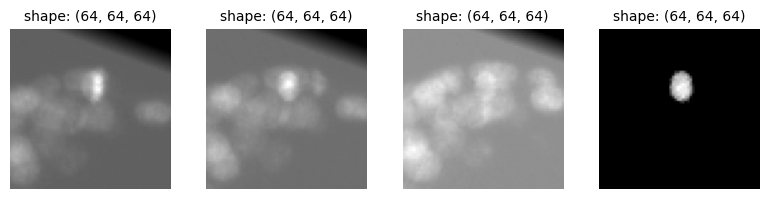

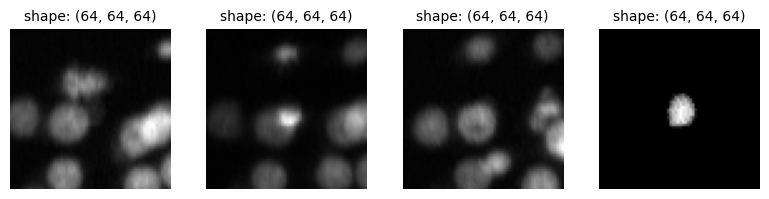

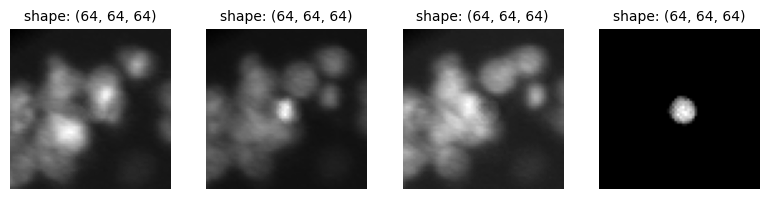

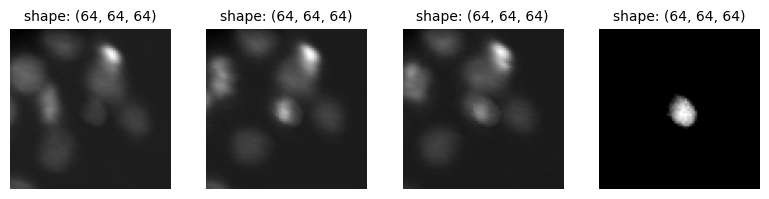

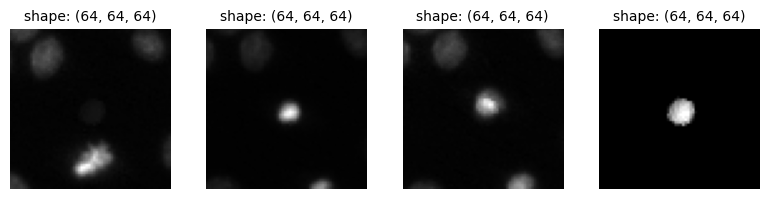

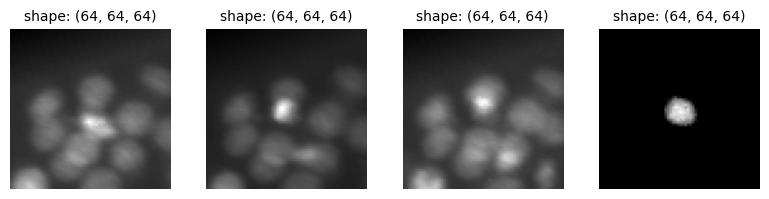

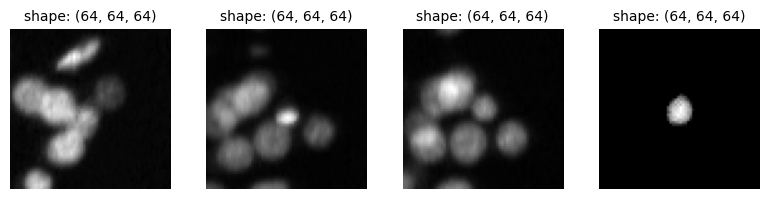

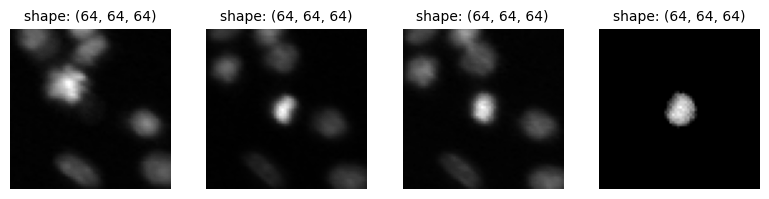

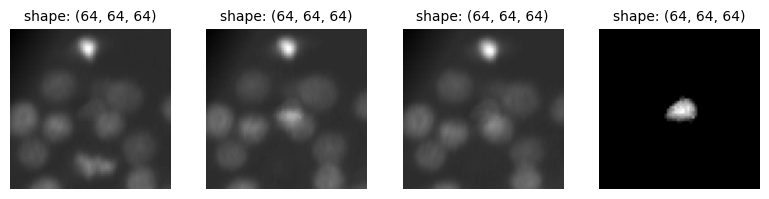

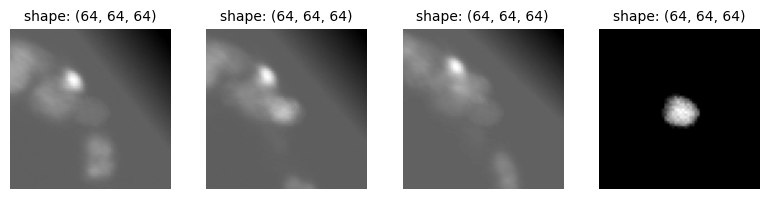

In [49]:
# NEW DAUGHTER
for file_path in datapoints["new_daughter"]:
    folder_path = os.path.join(BASE_DIR, "new_daughter", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path,
        save_analysis=False,
    )

    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'new_daughter'}")

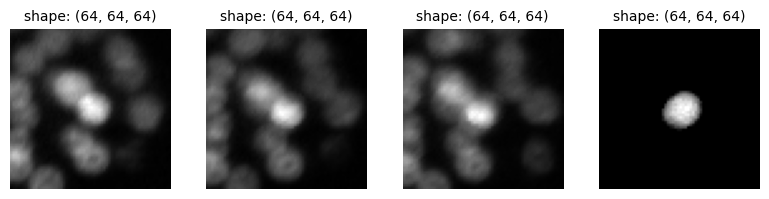

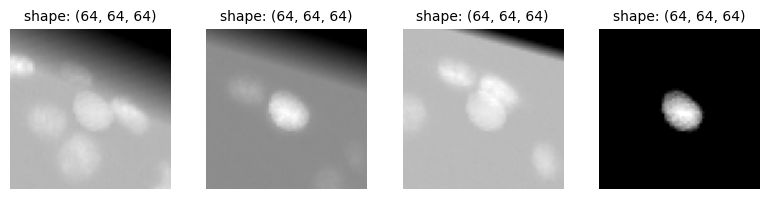

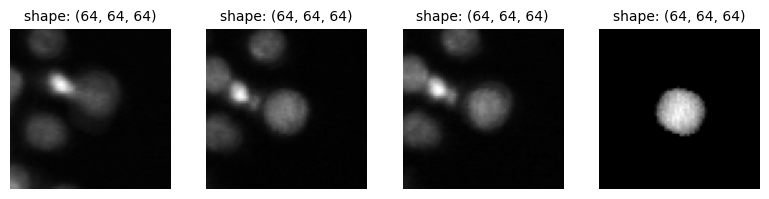

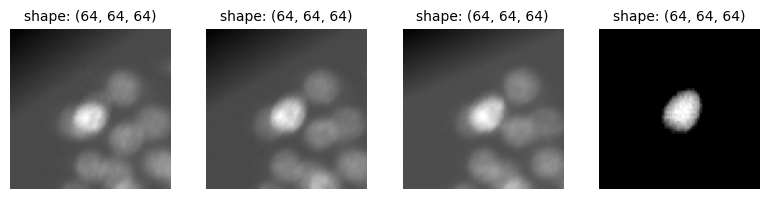

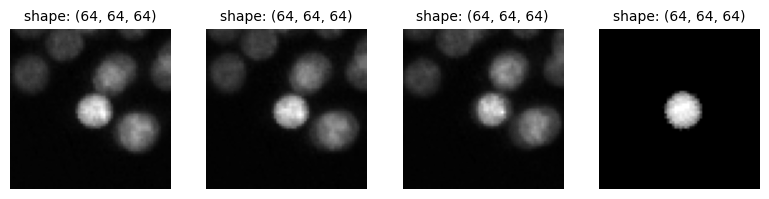

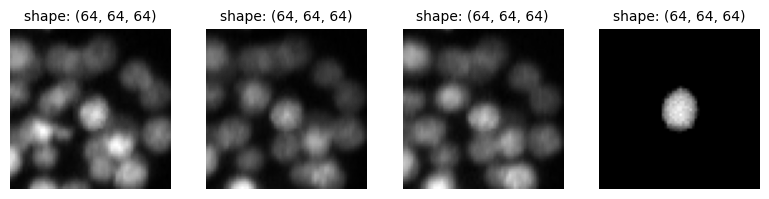

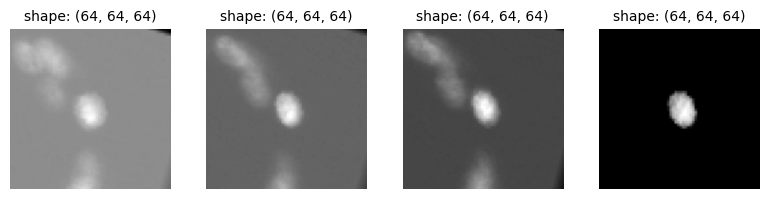

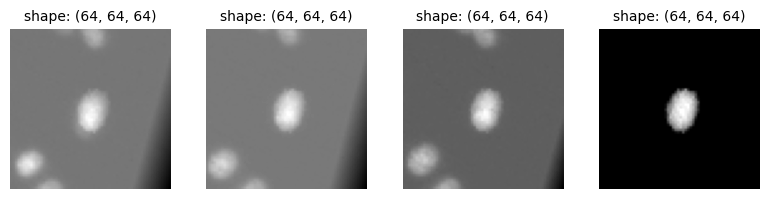

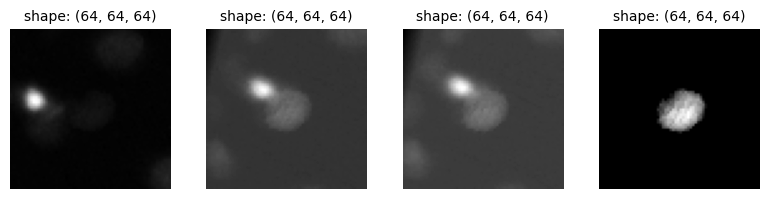

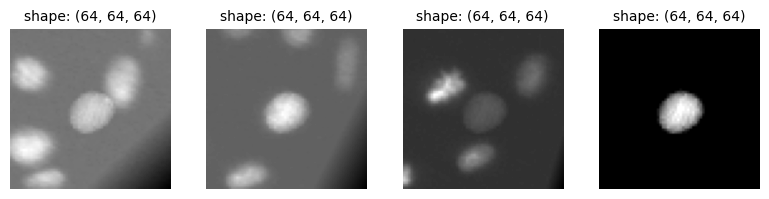

In [50]:
# STABLE
for file_path in datapoints["stable"]:
    folder_path = os.path.join(BASE_DIR, "stable", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path,
        save_analysis=False,
    )

    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'stable'}")

In [51]:
# DEATH
for file_path in datapoints["death"]:
    folder_path = os.path.join(BASE_DIR, "death", file_path)
    tensor = preprocess_sample(
        folder_path=folder_path,
        save_analysis=False,
    )

    tensor = tensor.numpy().astype(np.float32)
    tensor = tensor.squeeze(0)  # Remove batch dimension

    plot_grid(tensor, ncols=4, label=f"{file_path} {'death'}")

In [2]:
NUCLEUS_OF_INTEREST = 3
TIMESTAMP= 3

In [3]:
from tifffile import imread
from pathlib import Path

# ---- Parameters ----
center_time = TIMESTAMP  # or set directly, e.g., 5
nucleus_id = NUCLEUS_OF_INTEREST

# ---- Paths ----
label_path = Path(
    "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/220321_stack11/registered_label_images"
)
volume_path = Path(
    "/mnt/home/dchhantyal/3d-cnn-classification/raw-data/220321_stack11/registered_images"
)



# ---- Load label and mask from center timepoint ----
label_file = f"label_reg8_{center_time}.tif"
label_volume = imread(label_path / label_file)

print(f"Label volume shape: {label_volume.shape}"
      )
print(f"Label volume id: {np.unique(label_volume)}")
mask = label_volume == nucleus_id

# ---- Find bounding box ----
coords = np.argwhere(mask)
zmin, ymin, xmin = coords.min(axis=0)
zmax, ymax, xmax = coords.max(axis=0) + 1

# ---- Expand bounding box by 1.5x, centered ----
factor = 1.5
shape = label_volume.shape
cz = (zmin + zmax) // 2
cy = (ymin + ymax) // 2
cx = (xmin + xmax) // 2
dz = int((zmax - zmin) * factor / 2)
dy = int((ymax - ymin) * factor / 2)
dx = int((xmax - xmin) * factor / 2)
zmin_e = max(cz - dz, 0)
zmax_e = min(cz + dz, shape[0])
ymin_e = max(cy - dy, 0)
ymax_e = min(cy + dy, shape[1])
xmin_e = max(cx - dx, 0)
xmax_e = min(cx + dx, shape[2])

# ---- Load and crop raw volumes for t-1, t, t+1 ----
timepoints = [center_time - 1, center_time, center_time + 1]
cropped_raws = []
for t in timepoints:
    raw_file = f"nuclei_reg8_{t}.tif"
    raw_volume = imread(volume_path / raw_file)
    cropped_raw = raw_volume[zmin_e:zmax_e, ymin_e:ymax_e, xmin_e:xmax_e]
    cropped_raws.append(cropped_raw)

# ---- Crop mask for overlay ----
cropped_mask = mask[zmin_e:zmax_e, ymin_e:ymax_e, xmin_e:xmax_e]

# ---- Plot ----
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, (cropped_raw, t) in enumerate(zip(cropped_raws, timepoints)):
    axs[i].imshow(np.mean(cropped_raw, axis=2), cmap="gray")
    # axs[i].imshow(np.mean(cropped_mask, axis=0), alpha=0.4, cmap="jet")
    # axs[i].imshow(cropped_mask[len(cropped_mask)//2], alpha=0.4, cmap="jet")

    axs[i].set_title(f"Time {t} (center={center_time})")
    axs[i].axis("off")
plt.suptitle(f"Nucleus ID: {nucleus_id} (1.5x crop, mask from t={center_time})")
plt.tight_layout()
plt.show()

Label volume shape: (252, 512, 512)
Label volume id: [0]


ValueError: zero-size array to reduction operation minimum which has no identity

In [38]:
for t in range(120, 139):
    label_volume = imread(label_path / f"label_reg8_{t}.tif")
    print(f"Time {t}: Unique labels: {np.unique(label_volume)}")


Time 120: Unique labels: [  0   1   2   3   4   5   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56 144 145 146]
Time 121: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 61]
Time 122: Unique labels: [  0   3   4   5   7   8   9  10  11  12  13  14  15  17  19  20  22  24
  25  26  28  30  31  32  35  40  41  42  44  45  46  47  49  50  52  53
  54  55  56  58 116 117 147 148 149 150]
Time 123: Unique labels: [  0   1   4   5   6   7  10  11  12  13  14  15  16  18  20  21  22  24
  31  34  38  39  40  41  42  44  45  47  49  51  54  56  61 153]
Time 124: Unique labels: [ 0 24 28 46 52 53 54]
Time 125: Unique labels: [  0   1   2   3   4   5   6   9  14  16  17  18  19  20  21  22  24  27
  

In [ ]:
LOW_BOUND = 76
HIGH_BOUND = 100

In [23]:
label_path = Path("/mnt/ceph/users/lbrown/MouseData/Eszter1/registered_label_images")

for t in range(75, 90):
    label_volume = imread(label_path / f"label_reg8_{t}.tif")
    print(f"Time {t}: Unique labels: {np.unique(label_volume)}")

Time 75: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Time 76: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Time 77: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Time 78: Unique labels: [ 0  5 10 16 18 24 29 31]
Time 79: Unique labels: [  0   1   2   3   4   9  15  16  18  20  23  26  27  29  30  31  32 119
 120]
Time 80: Unique labels: [ 0  8  9 31]
Time 81: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Time 82: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33]
Time 83: Unique labels: [ 0  1  5  7 15 18 20 22 24 26 27 28 30 32]
Time 84: Unique labels: [ 0  1  2  3  4  5  6  7  8  9 11 12 13 14 15 16 17 18 19 20 21 22 23 24

In [39]:
TIMEPOINT = 132
raw_volume = imread(f"/mnt/ceph/users/lbrown/MouseData/Eszter1/registered_images/nuclei_reg8_{TIMEPOINT}.tif")
label_volume = imread(f"/mnt/ceph/users/lbrown/MouseData/Eszter1/registered_label_images/label_reg8_{TIMEPOINT}.tif")
print(f"Raw volume shape: {raw_volume.shape}")
print(f"Raw volume id: {np.unique(raw_volume)}")
print(f"Unqiue labels in label volume: {np.unique(label_volume)}")

Raw volume shape: (243, 512, 512)


Raw volume id: [ 0  2  3  4  5  6  7  8  9 10 11 12]
Unqiue labels in label volume: [0]


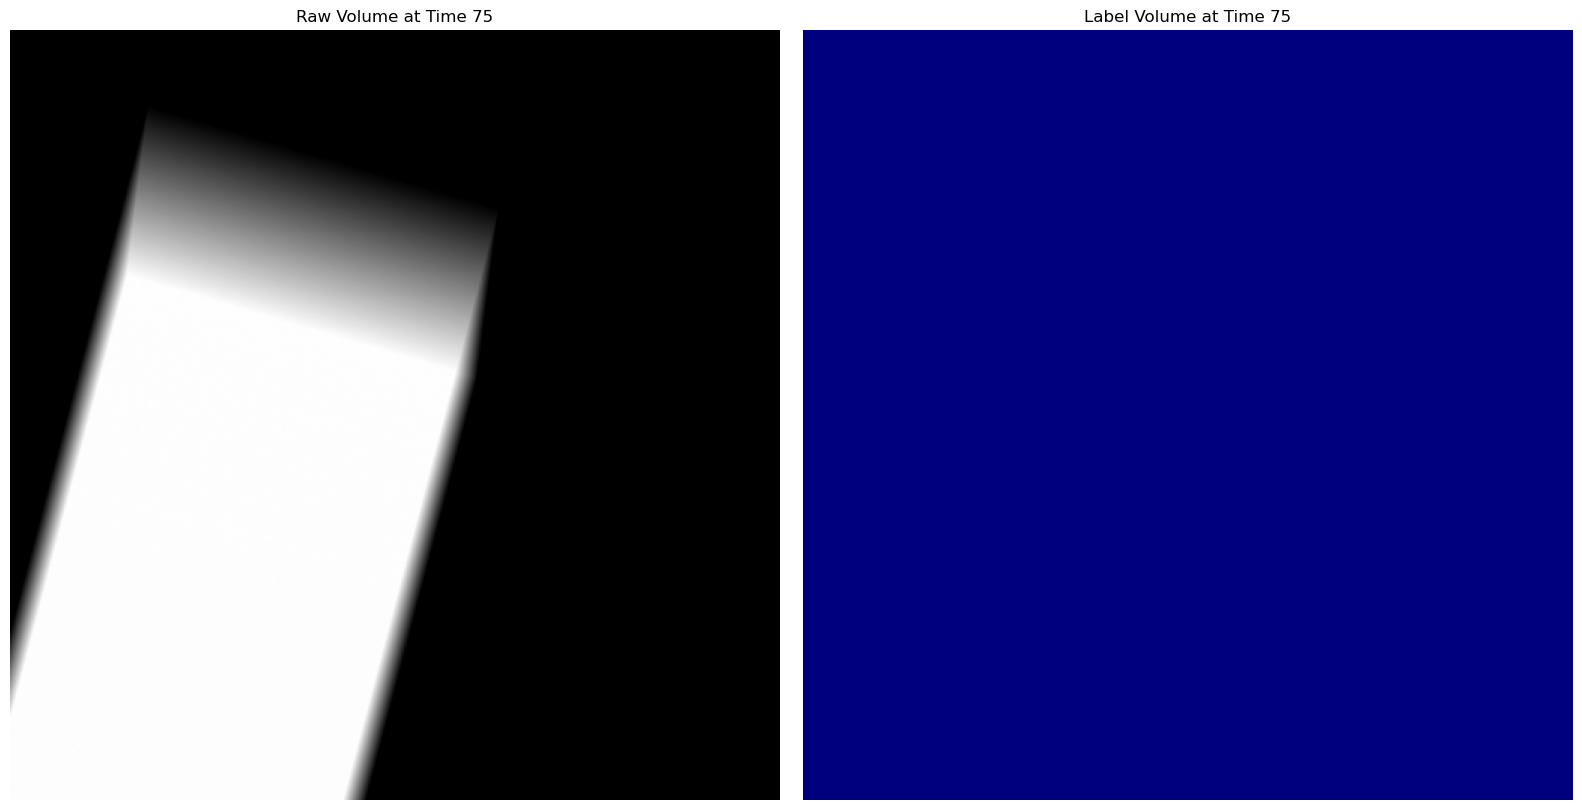

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
axs[0].imshow(np.mean(raw_volume, axis=0), cmap="gray")
axs[0].set_title("Raw Volume at Time 75")
axs[0].axis("off")

axs[1].imshow(np.mean(label_volume, axis=0), cmap="jet")
axs[1].set_title("Label Volume at Time 75")
axs[1].axis("off")

plt.tight_layout()
plt.show()